In [1]:
import torch
import torchvision
import cv2

In [2]:
import os
import numpy as np
import json
import random
import matplotlib.pyplot as plt
%matplotlib inline

# pip install 'git+https://github.com/facebookresearch/detectron2.git'

from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.logger import setup_logger
from detectron2.data.datasets import register_coco_instances

from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer

from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
import cv2
import pickle

In [3]:
#### Utils ####
def plot_samples(dataset_name, n=1):
    dataset_custom = DatasetCatalog.get(dataset_name)
    dataset_custom_metadata = MetadataCatalog.get(dataset_name)

    for s in random.sample(dataset_custom, n):
        img = cv2.imread(s["file_name"])
        v = Visualizer(img[:,:,::-1], metadata=dataset_custom_metadata, scale = 1)
        v = v.draw_dataset_dict(s)
        plt.figure(figsize=(5,5))
        plt.imshow(v.get_image())
        plt.show()

def get_train_cfg(config_file_path, checkpoint_url, train_dataset_name, test_dataset_name, num_classes, device, output_dir):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(config_file_path))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(checkpoint_url)
    cfg.DATASETS.TRAIN = (train_dataset_name,)
    cfg.DATASETS.TEST = (test_dataset_name,)
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.SOLVER.IMS_PER_BATCH = 5
    cfg.SOLVER.BASE_LR = 0.00025
    cfg.SOLVER.MAX_ITER = 3000
    cfg.SOLVER.STEPS = []
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes
    cfg.MODEL.DEVICE = device
    cfg.OUTPUT_DIR = output_dir

    return cfg 

def on_image(image_path, predictor):
    im = cv2.imread(image_path)
    outputs = predictor(im)
    print(outputs)
    v = Visualizer(im[:,:,::-1], metadata={}, scale =1, instance_mode=ColorMode.SEGMENTATION)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(5,5))
    plt.imshow(v.get_image())
    plt.show()


In [4]:
## If doing instance segmentation:
config_file_path = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
checkpoint_url = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
output_dir = "./output"
num_classes = 2

device = "cpu"

train_dataset_name = "LP_train"
train_images_path = "train"
train_json_annot_path = "train/_annotations.coco.json"

test_dataset_name = "LP_valid"
test_images_path = "valid"
test_json_annot_path = "valid/_annotations.coco.json"

cfg_save_path = "IS_cfg_cpu.pickle"

register_coco_instances(name = train_dataset_name, metadata={}, json_file=train_json_annot_path, image_root=train_images_path)
register_coco_instances(name = test_dataset_name, metadata={}, json_file=test_json_annot_path, image_root=test_images_path)

# plot_samples(train_dataset_name)

cfg = get_train_cfg(config_file_path, checkpoint_url, train_dataset_name, test_dataset_name, num_classes, device, output_dir)\

with open(cfg_save_path, 'wb') as f:
    pickle.dump(cfg, f, protocol=pickle.HIGHEST_PROTOCOL)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)



In [5]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume = False)

trainer.train()

[10/02 05:54:30 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

[10/02 05:54:31 d2.engine.train_loop]: Starting training from iteration 0


d:\venv\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[10/02 05:55:14 d2.utils.events]:  eta: 0:39:15  iter: 19  total_loss: 1.924  loss_cls: 0.9972  loss_box_reg: 0.03226  loss_mask: 0.6908  loss_rpn_cls: 0.1681  loss_rpn_loc: 0.02057  time: 1.0525  data_time: 0.1066  lr: 4.9953e-06  max_mem: 3856M
[10/02 05:55:37 d2.utils.events]:  eta: 0:47:32  iter: 39  total_loss: 1.727  loss_cls: 0.8519  loss_box_reg: 0.04253  loss_mask: 0.6831  loss_rpn_cls: 0.1237  loss_rpn_loc: 0.01775  time: 1.0990  data_time: 0.0184  lr: 9.9902e-06  max_mem: 3856M
[10/02 05:55:59 d2.utils.events]:  eta: 0:40:13  iter: 59  total_loss: 1.431  loss_cls: 0.5886  loss_box_reg: 0.03582  loss_mask: 0.6615  loss_rpn_cls: 0.1122  loss_rpn_loc: 0.0192  time: 1.0968  data_time: 0.0236  lr: 1.4985e-05  max_mem: 3856M
[10/02 05:56:12 d2.utils.events]:  eta: 0:35:12  iter: 79  total_loss: 1.212  loss_cls: 0.3553  loss_box_reg: 0.0435  loss_mask: 0.646  loss_rpn_cls: 0.1165  loss_rpn_loc: 0.01892  time: 0.9846  data_time: 0.0217  lr: 1.998e-05  max_mem: 3856M
[10/02 05:56:25 

cpu


d:\venv\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


{'instances': Instances(num_instances=1, image_height=3024, image_width=3024, fields=[pred_boxes: Boxes(tensor([[1084.3073, 1488.7089, 1940.5476, 1822.8381]])), scores: tensor([0.9979]), pred_classes: tensor([1]), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])])}


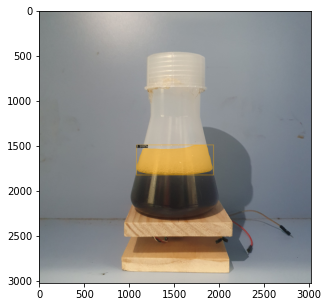

In [5]:

cfg_save_path = "IS_cfg_cpu.pickle"
with open(cfg_save_path, 'rb') as f:
    cfg = pickle.load(f)

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3

print(cfg.MODEL.DEVICE)
predictor = DefaultPredictor(cfg)

def test_output(dataset_name, n=1):
    dataset_custom = DatasetCatalog.get(dataset_name)
    dataset_custom_metadata = MetadataCatalog.get(dataset_name)

    for s in random.sample(dataset_custom, n):
        on_image(s["file_name"], predictor)

# test_output(test_dataset_name, 5)
image_path = "fg3.jpg"
on_image(image_path, predictor)